# Evaluating Scenario Outcomes With A/B Testing

## Introduction
A/B testing is a very common framework for comparing the outcomes of two scenarios and determining whether that comparison is significant and non-random. These could be two brand new scenarios or a new idea that you want to test against your current strategy. A/B testing will not only outright tell you which scenario is better but it will also tell you whether there is a statistical difference between the two.

This project will investigate two datasets with different inputs and goals. The subject of the first case study is a mobile game called *Cookie Cats* that looks at retention rate. The second case study that evaluates the effectiveness that an *AdSmart* advertisement has on the participation rate of a questionnaire for an online auction marketplace.
***
***

## Case Study 1: Cookie Cats - Mobile Game

Cookie Cats is a classic mobile puzzle game where you must connect three matching icons to get points and progress through the game's puzzles. As puzzles are completed users will gain experience points and level up their accounts which leads to them encountering more difficult puzzles and obtaining larger rewards. At certain levels there are **content gates** that require the user to wait a certain amount of time or make an in-game purchase before being able to continue solving puzzles and leveling up further. Cookie cats wants to test whether there is a difference between one scenario where the first content gate at level 30 and another scenario where the first content gate is at level 40. The metrics used to measure this potential difference are:
* total number of game rounds played
* retention after one day
* retention after seven days

The dataset was downloaded from Kaggle: https://www.kaggle.com/yufengsui/mobile-games-ab-testing

#### Data and Exploratory Analysis

In [1]:
#Import important packages
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt

There are 90189 unique users (rows) and 5 categories (columns) of data for each user. The categories that are included are:
* `userid`: The unique user ID number
* `version`: Which level the content gate was placed at  
    * gate_30: The users who were content gated at level 30
    * gate_40: The users who were content gated at level 40
* `sum_gamerounds`: The total number of rounds the user has played
* `retention_1`: Whether or not the user returned to the game 1 day after installation
* `retention_7`: Whether or not the user returned to the game 7 days after installation  

Once the data was loaded from .csv format it was inspected to determine if cleaning up needs to be done prior to the analysis.

In [2]:
# Load data from the .csv into a pandas data frame
ccats = pd.read_csv('cookie_cats.csv')
ccats

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True
...,...,...,...,...,...
90184,9999441,gate_40,97,True,False
90185,9999479,gate_40,30,False,False
90186,9999710,gate_30,28,True,False
90187,9999768,gate_40,51,True,False


All the columns within this dataset are relevant and they are all properly categorized as well as in a suitable format so it does not require any reshaping or a change in it's organization. The data is then checked for null or missing values that could cause errors to occur later on in the analysis. None were found.

In [3]:
#Check data set for missing or null values
ccats.isna().sum()

userid            0
version           0
sum_gamerounds    0
retention_1       0
retention_7       0
dtype: int64

The range of the `sum_gamerounds` was then checked to ensure that it was consistent and that there were no outliers. There was in fact one record with 50,000 game rounds recorded that was a clear outlier, likely a developer's account that was used for testing. It was removed so that it would not skew the rest of the data. Once that was done the range was much more consistent and visually similar between both scenarios.

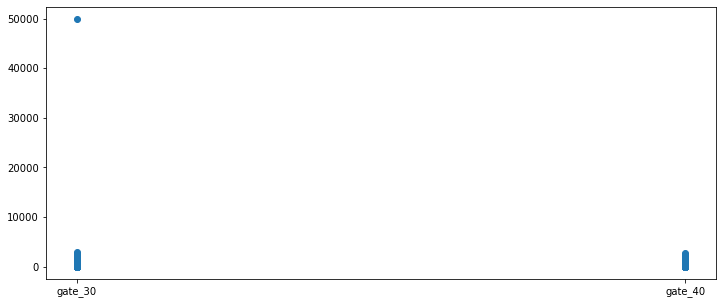

In [4]:
# Plot the sum_gameround distribution ofr each version
plt.figure(figsize = (12,5))
plt.scatter(x = ccats['version'], y = ccats['sum_gamerounds'])

In [5]:
# Remove all records with more than 10,000 total game rounds
ccats = ccats[ccats.sum_gamerounds < 10000]

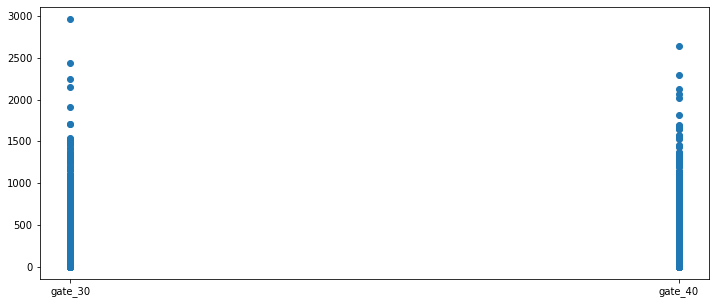

In [53]:
# Plot the sum_gameround distribution ofr each version
plt.figure(figsize = (12,5))
plt.scatter(x = ccats['version'], y = ccats['sum_gamerounds'])

The distribution of `sum_gamerounds` was also plotted to get a more detailed look at how this metric differed from one scenario to the next. A log y-axis was used to show this distribution more clearly. There was very little divergence between the two gates until you reached the upper limits of the games rounds played. This makes sense as it is less likely for users to reach those totals and more variance is expected with a smaller sample size. 

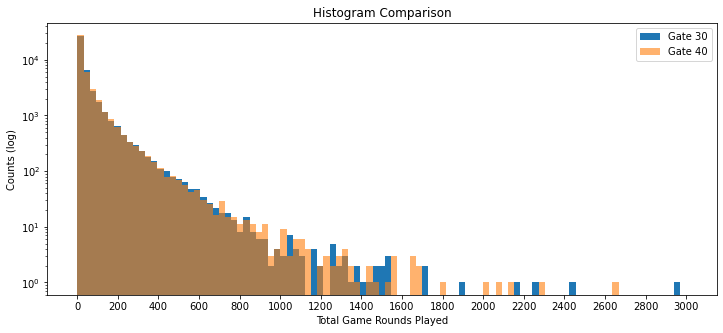

In [46]:
# Plotting the histograms of game rounds played for both gate 30  and gate 40
plt.figure(figsize = (12,5))
numBins = np.linspace(1, 3000, 100)
# Gate 30 histogram
plt.hist(ccats['sum_gamerounds'].where(ccats['version'] == 'gate_30'), numBins, label = 'Gate 30')
# Gate 40 histogram - 60% transparency
plt.hist(ccats['sum_gamerounds'].where(ccats['version'] == 'gate_40'), numBins, label = 'Gate 40', alpha = 0.6)
# Plot elements
plt.title('Histogram Comparison')
plt.ylabel('Counts (log)')
plt.xlabel('Total Game Rounds Played')
plt.yscale('log')
plt.xticks(np.arange(0,3001, step = 200))
plt.legend()
plt.show()

A visual inspection of the retention columns was then conducted for two purposes. The first was to ensure that there was not a class imbalance between the two scenarios at any retention level. The second was to see if there were any obvious differences between the 4 metric groups that could be used to double check the numeric analysis that will follow later in this project. 

In [8]:
# Creating variables for number of users in each of the 4 categories

# Number of users in version: gate_30 who returned after 1 day
thirtyOneT = len(ccats.loc[(ccats['version'] == 'gate_30') & (ccats['retention_1'] == True)])
# Number of users in version: gate_40 who returned after 1 day
fortyOneT = len(ccats.loc[(ccats['version'] == 'gate_40') & (ccats['retention_1'] == True)])
# Number of users in version: gate_30 who did not return after 1 day
thirtyOneF = len(ccats.loc[(ccats['version'] == 'gate_30') & (ccats['retention_1'] == False)])
# Number of users in version: gate_40 who did not return after 1 day
fortyOneF = len(ccats.loc[(ccats['version'] == 'gate_40') & (ccats['retention_1'] == False)])

# Number of users in version: gate_30 who returned after 7 days
thirtySevenT = len(ccats.loc[(ccats['version'] == 'gate_30') & (ccats['retention_7'] == True)])
# Number of users in version: gate_40 who returned after 7 days
fortySevenT = len(ccats.loc[(ccats['version'] == 'gate_40') & (ccats['retention_7'] == True)])
# Number of users in version: gate_30 who did not return after 7 days
thirtySevenF = len(ccats.loc[(ccats['version'] == 'gate_30') & (ccats['retention_7'] == False)])
# Number of users in version: gate_40 who did not return after 7 days
fortySevenF = len(ccats.loc[(ccats['version'] == 'gate_40') & (ccats['retention_7'] == False)])

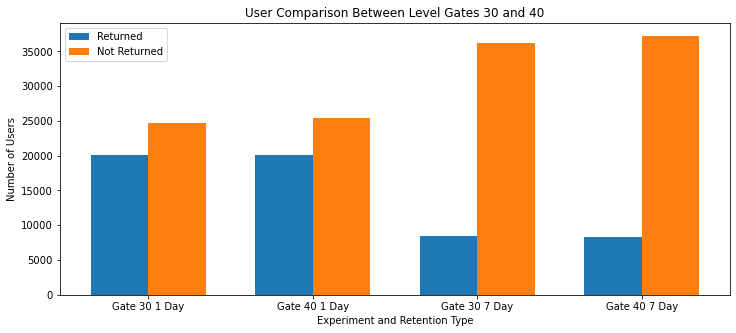

In [37]:
# Setting up the format variables for the bar graph
# Label names
labels = ['Gate 30 1 Day', 'Gate 40 1 Day', 'Gate 30 7 Day', 'Gate 40 7 Day']
# Array of returned user totals
trueGates = [thirtyOneT, fortyOneT, thirtySevenT, fortySevenT]
# Array of not returned iser totals
falseGates = [thirtyOneF, fortyOneF, thirtySevenF, fortySevenF]
# Bar width
width = 0.35
# Number of labels
labelLen = np.arange(len(labels))

# Creating the side-by-side bar graph
fig, ax = plt.subplots(figsize = (12,5))
gate1 = ax.bar(labelLen - width/2, trueGates, width, label = 'Returned')
gate2 = ax.bar(labelLen + width/2, falseGates, width, label = 'Not Returned')

# Graph elements
ax.set_ylabel('Number of Users')
ax.set_xlabel('Experiment and Retention Type')
ax.set_title('User Comparison Between Level Gates 30 and 40')
ax.set_xticks(labelLen)
ax.set_xticklabels(labels)
ax.legend()

plt.show()

It is evident from this plot that the dataset is evenly divided between the two scenarios and that they both follow very similar trends when it comes to user retention between the one and seven day intervals. 

From this point we can't make any confident assumptions regarding which content level gate resulted in more retention or more game rounds played. This is where A/B tests truly shine. They can take very marginal differences between the outcomes of two scenarios and determine whether there is a statistically significant difference or whether we could have encountered these results randomly if there was no difference. 

#### Preliminary Comparisons

From the EDA and visual inspection of the plots above we can tell that the two scenarios are very similar with consistent distributions and patterns. The three metrics that will be compared to evaluate whether these scenarios are different are:  
* Mean game rounds played (`sum_gamerounds`)
* One day retention rate (`retention_1`)
* Seven day retention rate (`retention_7`) 

The first step is to calculate the differences in each metric between the two scenarios.

In [10]:
# Mean game rounds played for each gate
meanThirty = ccats.loc[ccats['version'] == 'gate_30', 'sum_gamerounds'].mean()
meanForty = ccats.loc[ccats['version'] == 'gate_40', 'sum_gamerounds'].mean()

# Retention rates for (gate30 ret 1), (gate40 ret 1), (gate30 ret 7), (gate40 ret 7)
totalThirty = len(ccats.loc[(ccats['version'] == 'gate_30')])
totalForty = len(ccats.loc[(ccats['version'] == 'gate_40')])

rateThirtyOne = round((thirtyOneT/totalThirty)*100,2)
rateThirtySeven = round((thirtySevenT/totalThirty)*100,2)

rateFortyOne = round((fortyOneT/totalForty)*100,2)
rateFortySeven = round((fortySevenT/totalForty)*100,2)

print(f"The mean game rounds for the level 30 gate vs the level 40 gate is: {round(meanThirty,3)} vs. {round(meanForty,3)}")
print(f"The 1 day retention rate for the level 30 gate vs the level 40 gate is: {rateThirtyOne}% vs. {rateFortyOne}%")
print(f"The 7 day retention rate for the level 30 gate vs the level 40 gate is: {rateThirtySeven}% vs. {rateFortySeven}%")

The mean game rounds for the level 30 gate vs the level 40 gate is: 51.342 vs. 51.299
The 1 day retention rate for the level 30 gate vs the level 40 gate is: 44.82% vs. 44.23%
The 7 day retention rate for the level 30 gate vs the level 40 gate is: 19.02% vs. 18.2%


From the numerical comparison of the metrics we can make the following declarations:
* Mean game rounds played **decreased** by 0.043 when the first content gate was moved from level 30 to level 40
* The one day retention rate **decreased** by 0.59% when the first content gate was moved from level 30 to level 40
* The seven day retention rate **decreased** by 0.82% when the first content gate was moved from level 30 to level 40

From these results we *could* make the conclusion that there was a difference in all three metrics when moving the first content gate level and that it was detrimental to the overall product because all three metrics decreased. What we cannot do is say these results are statistically significant, that is to say we do not know whether these decreases could be randomly encountered if no difference existed. 

#### Statistical Analysis

To determine whether the decreases in our metrics are statistically significant, a proportion z-test test will be used to test our two hypotheses. This test will take into account both the number of occurrences as well as the total number of observations which will help balance out the slight imbalance of samples in each scenario. Our null hypothesis ($H_0$) for this experiment will be: *the difference between the two scenarios is 0*. The alternative hypothesis ($H_1$) will be: *the difference between the two scenarios is not 0*.


$$ H_0 : d = 0 \; \; \; \text{vs}\; \; \; H_1 : d \neq 0 $$

$$H_0: \; \; \text{ The difference between the two scenarios is 0}\; $$

$$H_1: \; \; \text{ The difference between the two scenarios is not 0}\; $$


It is important to note that these tests will not definitively tell us the direct cause of the difference between the scenarios, just whether they are different or not. It will tell us the probability (p-value) that these results would be **encountered under random circumstances given our null hypothesis is true (that there are is no difference between the scenarios)**. It is up to those conducting the experiment to set the threshold at which we will accept that there is a statistically significant (non-random) difference between the results. The standard threshold of 0.05 will be used for this project, our calculated p-values must be below this threshold for them to be considered statistically significant. 

In [11]:
# Proportion z-test package load
from statsmodels.stats.proportion import proportions_ztest

##### Game Rounds Played

In [12]:
# Proportion z-test for the mean game rounds played
meanGates = [meanThirty, meanForty]
meanObs =  [totalThirty, totalForty]
print(f"The p-value for the mean gamerounds between the gate 30 and gate 40 users is: {proportions_ztest(meanGates, meanObs)[1]}")

The p-value for the mean gamerounds between the gate 30 and gate 40 users is: 0.9258417189307235


With a p-value of 0.9258 we cannot reject the null hypothesis and therefore cannot conclude that there is a meaningful difference in <font color=yellow>game rounds played</font> by the users in both scenarios. There is a 92.58% probability of randomly observing our data given that the difference between the two scenarios is 0. 

##### One Day Retention

In [13]:
# Proportion z-test for one day retention
retOneCount = [thirtyOneT, fortyOneT]
retOneObs =  [totalThirty, totalForty]
print(f"The p-value for the one day retention rate between the gate 30 and gate 40 users is: {proportions_ztest(retOneCount, retOneObs)[1]}")

The p-value for the one day retention rate between the gate 30 and gate 40 users is: 0.0739207603418346


With a p-value of 0.0739 we cannot reject the null hypothesis and therefore cannot conclude that there is a meaningful difference in <font color=yellow>one day retention</font> by the users in both scenarios. There is a 7.39% probability of randomly observing our data given that the difference between the two scenarios is 0. 

##### Seven Day Retention

In [14]:
retSevenCount = [thirtySevenT, fortySevenT]
retSevenObs =  [totalThirty, totalForty]
print(f"The p-value for the seven day retention rate between the gate 30 and gate 40 users is: {proportions_ztest(retSevenCount, retSevenObs)[1]}")

The p-value for the seven day retention rate between the gate 30 and gate 40 users is: 0.0015917731773993442


With a p-value of 0.0016 we can reject the null hypothesis and therefore we may conclude that there is a meaningful difference in <font color=yellow>seven day retention</font> by the users in both scenarios. There is a 0.16% probability of randomly observing our data given that the difference between the two scenarios is 0. 

#### Conclusions

There was a 0.043 drop in game rounds played between the gate 30 group and the gate 40 group. Through a proportional z-test it was determined that the difference between the two scenarios was not statistically different. <font color=red>**With the data currently available we cannot say that there was a difference in the one day retention rate.**</font>

There was a 0.59% drop in one day retention rate between the gate 30 group and the gate 40 group. Through a proportional z-test it was determined that the difference between the two scenarios was not statistically different. <font color=red>**With the data currently available we cannot say that there was a difference in the one day retention rate.**</font>

There was a 0.82% drop in seven day retention rate between the gate 30 group and the gate 40 group. Through a proportional z-test it was determined that the difference between the two scenarios was statistically different. <font color=green>**With the data currently available we can say that there was a significant drop in the seven day retention rate.**</font>

This experiment was not able to conclude whether shifting the first content level gate from level 30 to level 40 had an affect on the mean game rounds played or the one day retention rate. It was able to determine that there was a decrease in seven day retention rate of 0.82% that was proven to be statistically significant based on a p-value threshold of 0.05. Based on those results this report would suggest that the first content level gate be placed at level 30 to avoid the significant drop in seven day retention.

***
***

## Case Study 2: AdSmart Questionnaire Participation

AdSmart is a marketing company who was hired by an online auction marketplace to create an ad that would increase participation in their customer satisfaction questionnaire. AdSmart created a creative and interactive ad to promote this questionnaire and the data resulting from the users who saw that ad and those who saw a generic dummy ad is the subject of the this case study. The focus points of this dataset are the experiment group, exposed or control, and whether or not they interacted with the questionnaire ,yes or no. There is also a number of other metrics included that can be used to pinpoint whether the AdSmart ads were performing better in some environments versus others. 

This dataset was downloaded from Kaggle: https://www.kaggle.com/osuolaleemmanuel/ad-ab-testing

#### Exploratory Data Analysis and Data Cleaning

Once the data was loaded from .csv format it was inspected to determine if any cleaning or reorganization was needed prior to the analysis. There are 8077 unique ids (rows) and 9 categories (columns) of data for each id. The categories that are included in the original dataset are:
* `auction_id`: the unique id of the user who has seen an opportunity to participate in the questionnaire
* `experiment`: In what form the opportunity to participate in the questionnaire
    * control: shown a generic dummy ad
    * exposed: shown the create and interactive AdSmart ad
* `date`: the date the user was presented the questionnaire.
* `hour`: in what hour the user was presented the questionnaire.
* `device_make`: the model of the device the ad was viewed on.
* `platform_os`: the id of the operating system the user has.
* `browser`: what browser was used to see the ad.
* `yes`: 1 if the user agreed to participate in the questionnaire.
* `no`: 1 if the user declined to participate in the questionnaire.
    * *if the user completely ignored the questionnaire both the yes and no columns will be 0*

In [15]:
# Load and display the original dataset
adSmart = pd.read_csv('AdSmartABdata - AdSmartABdata.csv')
adSmart

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
0,0008ef63-77a7-448b-bd1e-075f42c55e39,exposed,2020-07-10,8,Generic Smartphone,6,Chrome Mobile,0,0
1,000eabc5-17ce-4137-8efe-44734d914446,exposed,2020-07-07,10,Generic Smartphone,6,Chrome Mobile,0,0
2,0016d14a-ae18-4a02-a204-6ba53b52f2ed,exposed,2020-07-05,2,E5823,6,Chrome,0,1
3,00187412-2932-4542-a8ef-3633901c98d9,control,2020-07-03,15,Samsung SM-A705FN,6,Facebook,0,0
4,001a7785-d3fe-4e11-a344-c8735acacc2c,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,0,0
...,...,...,...,...,...,...,...,...,...
8072,ffea24ec-cec1-43fb-b1d1-8f93828c2be2,exposed,2020-07-05,7,Generic Smartphone,6,Chrome Mobile,0,0
8073,ffea3210-2c3e-426f-a77d-0aa72e73b20f,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,0,0
8074,ffeaa0f1-1d72-4ba9-afb4-314b3b00a7c7,control,2020-07-04,9,Generic Smartphone,6,Chrome Mobile,0,0
8075,ffeeed62-3f7c-4a6e-8ba7-95d303d40969,exposed,2020-07-05,15,Samsung SM-A515F,6,Samsung Internet,0,0


To begin the clean up of the original dataset the main metrics need to be scrutinized to make sure they can be used for the A/B testing. The `experiment` column is binary and shows which of the two scenarios the user was presented with. No changes need to be made for this metric.

Having both `yes` and `no` columns is redundant as we are only interested in whether the ads were effective at *increasing participation* and not whether the questionnaire was accepted, declined, or ignored. Simply dropping the `no` column will result in a binary metric that indicates whether the questionnaire was taken or not. The `yes` column will also be renamed to `questionnaire` to reflect this change.

In [16]:
# Drop the 'no' column from the dataset
adSmart.drop(['no'], axis = 1, inplace = True)

# Rename the 'yes' column to 'questionnaire'
adSmart.rename(columns= {'yes': 'questionaire'}, inplace = True)

# Print the number of users that did and did not participate in the questionnaire
print(f"There were {adSmart.questionaire.value_counts()[1]} users that participated in the questionaire.")
print(f"There were {adSmart.questionaire.value_counts()[0]} users that did not participated in the questionaire.")

There were 572 users that participated in the questionaire.
There were 7505 users that did not participated in the questionaire.


Now that the primary metrics are formatted in a suitable manner the secondary metrics will be explored with the goal of creating some additional scenarios in which we can further test the performance of the AdSmart ad. The `browser` column can easily be distilled into three broader categories: Mobile, Desktop, and Application. Doing so will allow us to test whether the ad performed differently on various platforms. The `browser` column will then be renamed to `platform`.

In [54]:
# List the unique browser classes and their counts
adSmart.browser.value_counts()

Mobile         5817
Desktop        1493
Application     767
Name: browser, dtype: int64

In [56]:
# Combine the mobile browser entries into a single Mobile category
adSmart.browser.replace(['Chrome Mobile',
                         'Samsung Internet',
                         'Mobile Safari',
                         'Chrome Mobile iOS',
                         'Mobile Safari UI/WKWebView',
                         'Opera Mobile',
                         'Firefox Mobile',
                         'Android',
                         'Edge Mobile',
                         'Puffin'],'Mobile', inplace = True)

# Combine the desktop browser entries into a single Desktop category
adSmart.browser.replace(['Chrome',
                         'Opera Mini'],'Desktop', inplace = True)

# Combine the application browser entries into a single Application category
adSmart.browser.replace(['Facebook',
                         'Pinterest'],'Application', inplace = True)

# Rename the browser metric to platform
adSmart.rename(columns= {'browser': 'platform'}, inplace = True)

In [57]:
# Review the category changes for the browser metric
adSmart.platform.value_counts()

Mobile         5817
Desktop        1493
Application     767
Name: platform, dtype: int64

The `hour` column will be processed in a similar manner. The hours will be recategorized into Morning (0500 - 1200), Evening (1300 - 1800), and Night (1900 - 0400). This will create another set of scenarios in which to test the effectiveness of the AdSmart ad. The column will also be renamed to `timeOfDay` to stay in line with the category changes we made.

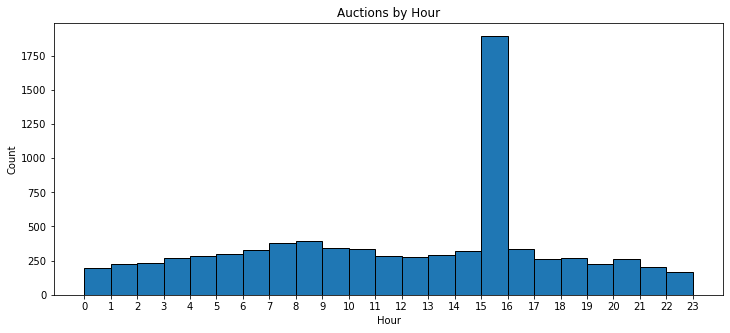

In [21]:
# Plot a histogram of the hour metric to check the distribution
xtix = np.arange(0,24)
plt.figure(figsize = (12,5))
plt.hist(adSmart['hour'], edgecolor='black', bins = 23)
plt.xlabel('Hour')
plt.ylabel('Count')
plt.title('Auctions by Hour')
plt.xticks(xtix)
plt.show()

In [22]:
# Re-categorize the hours in to Morning, Evening, and Night
adSmart.hour.replace([5, 6, 7, 8, 9, 10, 11, 12],'Morning', inplace = True)
adSmart.hour.replace([13, 14, 15, 16, 17, 18],'Evening', inplace = True)
adSmart.hour.replace([19, 20, 21, 22, 23, 0, 1, 2, 3, 4],'Night', inplace = True)

# Rename the hour metric to timeOfDay
adSmart.rename(columns= {'hour': 'timeOfDay'}, inplace = True)

In [23]:
# Review the category changes to the hour metric
adSmart.timeOfDay.value_counts()

Evening    3375
Morning    2646
Night      2056
Name: timeOfDay, dtype: int64

To finish up the cleaning and exploration process the `date`, `device_make`, and `platform_os` columns will be dropped as these columns do not add any useful information. The length of the experiment was only 1 week long which is not long enough for the `date` to provide multiple entries for the same day of the week therefore the it cannot factor into the analysis. The `device_make` is far too specific while the `platform_os` metric is too imbalanced to provide any additional information for this analysis.

In [24]:
# Display device_make categories and their counts
adSmart.device_make.value_counts()

Generic Smartphone    4743
iPhone                 433
Samsung SM-G960F       203
Samsung SM-G973F       154
Samsung SM-G950F       148
                      ... 
Swift 2 Plus             1
Samsung GT-I9195I        1
Samsung SM-N910F         1
Samsung SM-G570F         1
Armor_3                  1
Name: device_make, Length: 269, dtype: int64

In [25]:
# Display platform_os categories and their counts
adSmart.platform_os.value_counts()

6    7648
5     428
7       1
Name: platform_os, dtype: int64

In [26]:
# Display date categories and their counts
adSmart.date.value_counts()

2020-07-03    2015
2020-07-09    1208
2020-07-08    1198
2020-07-04     903
2020-07-10     893
2020-07-05     890
2020-07-06     490
2020-07-07     480
Name: date, dtype: int64

In [27]:
# Drop 'date', 'device_make', and 'platform_os' columns from the dateset
adSmart.drop(['date', 'device_make', 'platform_os'], axis =1, inplace = True)

The dataset is now free of redundant and useless data and it also feature recategorized metrics that will create opportunities to test additional scenarios.

In [58]:
# Display the reformatted and cleaned dataset
adSmart

,auction_id,experiment,timeOfDay,platform,questionaire
0,0008ef63-77a7-448b-bd1e-075f42c55e39,exposed,Morning,Mobile,0
1,000eabc5-17ce-4137-8efe-44734d914446,exposed,Morning,Mobile,0
2,0016d14a-ae18-4a02-a204-6ba53b52f2ed,exposed,Night,Desktop,0
3,00187412-2932-4542-a8ef-3633901c98d9,control,Evening,Application,0
4,001a7785-d3fe-4e11-a344-c8735acacc2c,control,Evening,Mobile,0
...,...,...,...,...,...
8072,ffea24ec-cec1-43fb-b1d1-8f93828c2be2,exposed,Morning,Mobile,0
8073,ffea3210-2c3e-426f-a77d-0aa72e73b20f,control,Evening,Mobile,0
8074,ffeaa0f1-1d72-4ba9-afb4-314b3b00a7c7,control,Morning,Mobile,0
8075,ffeeed62-3f7c-4a6e-8ba7-95d303d40969,exposed,Evening,Mobile,0


#### Analysis

Similar to the process in the first case study, the outcomes from the different scenarios will be compared numerically and then tested using a proportion z-test to determine whether the difference between the two outcomes is statistically significant.

There will be 3 scenarios whose outcomes will be analyzed:
* Control vs. Exposed experiment 
* Exposed users at three different time periods
* Exposed users on three different platform types

##### AdSmart vs. Generic Control Advertisements

The first outcomes that will be compared are those between the users who were given the generic dummy ad and those who were given the AdSmart ad.

In [29]:
# Counts of users who participated in the questionnaire for each experiment type
controlCount = len(adSmart.loc[((adSmart['questionaire']) == 1) & (adSmart['experiment'] == 'control')])
exposedCount = len(adSmart.loc[((adSmart['questionaire']) == 1) & (adSmart['experiment'] == 'exposed')])

# Counts of the total users for each experiment type
controlObs = len(adSmart.loc[(adSmart['experiment']) == 'control'])
exposedObs = len(adSmart.loc[(adSmart['experiment']) == 'exposed'])

# Calculating the participation rate of each experiment type
rateControl = round((controlCount/controlObs)*100,2)
rateExposed = round((exposedCount/exposedObs)*100,2)
print(f"The participation rate for the control vs the exposed is: {rateControl}% vs. {rateExposed}%")

The participation rate for the control vs the exposed is: 6.48% vs. 7.69%


In [30]:
# Proportion z-test for the control vs. exposed experiments
partCount = [controlCount, exposedCount]
partObs =  [controlObs, exposedObs]
print(f"The p-value for the one day retention rate for the control and moved users is: {proportions_ztest(partCount, partObs)[1]}")

The p-value for the one day retention rate for the control and moved users is: 0.035005825968324515


There was an increase of 1.21% in the participation rate for those users who were presented the AdSmart ad for the questionnaire. With a p-value of 0.0350 we can reject the null hypothesis and therefore can conclude that there is a meaningful difference in the participation by the users in both scenarios. There is a 3.50% probability of observing our data given that the difference between the two scenarios is 0. 

Now that there is confirmation that the AdSmart ad had a significant positive increase in the participation rate of the questionnaire additional scenarios can be investigated.

##### Time of Day
The following steps will determine whether or not we see a difference in the participation rate for users encountering the AdSmart ad at different times of the day.

In [31]:
# Counts of users who participated in the questionnaire for each time period
morningCount = len(adSmart.loc[((adSmart['questionaire']) == 1) & (adSmart['timeOfDay'] == 'Morning')])
eveningCount = len(adSmart.loc[((adSmart['questionaire']) == 1) & (adSmart['timeOfDay'] == 'Evening')])
nightCount = len(adSmart.loc[((adSmart['questionaire']) == 1) & (adSmart['timeOfDay'] == 'Night')])

# Counts of the total users for each time period
morningObs = len(adSmart.loc[(adSmart['timeOfDay']) == 'Morning'])
eveningObs = len(adSmart.loc[(adSmart['timeOfDay']) == 'Evening'])
nightObs = len(adSmart.loc[(adSmart['timeOfDay']) == 'Night'])

# Calculating the participation rate of each time period
rateMorning = round((morningCount/morningObs)*100,2)
rateEvening = round((eveningCount/eveningObs)*100,2)
rateNight = round((nightCount/nightObs)*100,2)
print(f"The participation rate for different time periods are:\n {rateMorning}% for the morning\n {rateEvening}% for the evening\n {rateNight}% for the night.")

The participation rate for different time periods are:
 7.07% for the morning
 6.76% for the evening
 7.64% for the night.


The difference in participation rate between the night and evening time periods is the largest at an increase of 0.88% therefore if the difference between those two is significant we can continue to the other possible pairs otherwise we can conclude that they too are not significant.

In [32]:
# Proportion z-test for the evening vs. night time periods
partENCount = [eveningCount, nightCount]
partENObs =  [eveningObs, nightObs]
proportions_ztest(partENCount, partENObs)

(-1.2265307272737305, 0.21999901949494727)

With a p-value of 0.2200 we cannot reject the null hypothesis and therefore cannot conclude that there is a meaningful difference in the participation by the users in both time periods. There is a 22.00% probability of observing our data given that the difference between the two scenarios is 0.

##### Platform Type
The next scenario to be tested is whether there was a difference in participation between users getting the AdSmart ad on different platform types.

In [33]:
# Counts of users who participated in the questionnaire for each browser type
desktopCount = len(adSmart.loc[((adSmart['questionaire']) == 1) & (adSmart['platform'] == 'Desktop')])
mobileCount = len(adSmart.loc[((adSmart['questionaire']) == 1) & (adSmart['platform'] == 'Mobile')])
appCount = len(adSmart.loc[((adSmart['questionaire']) == 1) & (adSmart['platform'] == 'Application')])

# Counts of the total users for each browser type
desktopObs = len(adSmart.loc[(adSmart['platform']) == 'Desktop'])
mobileObs = len(adSmart.loc[(adSmart['platform']) == 'Mobile'])
appObs = len(adSmart.loc[(adSmart['platform']) == 'Application'])

# Calculating the participation rate of each browser type
rateDesktop = round((desktopCount/desktopObs)*100,2)
rateMobile = round((mobileCount/mobileObs)*100,2)
rateApp = round((appCount/appObs)*100,2)
print(f"The participation rate for different times of the day is:\n {rateDesktop}% on Desktop\n {rateMobile}% on Mobile\n {rateApp}% on Applications.")

The participation rate for different times of the day is:
 7.84% on Desktop
 6.64% on Mobile
 9.0% on Applications.


The difference in participation rate between the Application and Mobile browser types is the largest therefore if the difference between those two is significant we can continue to the other pairs otherwise we can conclude that they too are not significant.

In [34]:
# Proportion z-test for the Mobile vs. Application browser types
partMACount = [mobileCount, appCount]
partMAObs =  [mobileObs, appObs]
print(f"The p-value between mobile and application exposed participation is: {proportions_ztest(partMACount, partMAObs)[1]}")

The p-value between mobile and application exposed participation is: 0.015412436404582513


With a p-value of 0.0154 we can reject the null hypothesis and therefore can conclude that there is a meaningful difference in the participation by the users in both time periods. There is a 1.54% probability of observing our data given that the difference between the two scenarios is 0. 

In [35]:
# Proportion z-test for the Desktop vs. Application browser types
partDACount = [desktopCount, appCount]
partDAObs =  [desktopObs, appObs]
print(f"The p-value between desktop and application exposed participation is: {proportions_ztest(partDACount, partDAObs)[1]}")

The p-value between desktop and application exposed participation is: 0.3422513590998233


With a p-value of 0.3423 we cannot reject the null hypothesis and therefore cannot conclude that there is a meaningful difference in the participation by the users in both time periods. There is a 34.23% probability of observing our data given that the difference between the two scenarios is 0. 

In [36]:
# Proportion z-test for the Desktop vs. Mobile browser types
partDMCount = [desktopCount, mobileCount]
partDMObs =  [desktopObs, mobileObs]
print(f"The p-value between desktop and mobile exposed participation is: {proportions_ztest(partDMCount, partDMObs)[1]}")

The p-value between desktop and mobile exposed participation is: 0.10201238471502544


With a p-value of 0.1020 we cannot reject the null hypothesis and therefore cannot conclude that there is a meaningful difference in the participation by the users in both time periods. There is a 10.20% probability of observing our data given that the difference between the two scenarios is 0. 

#### Conclusions

There was a 1.21% increase in the participation rate by the users who were presented the AdSmart ad versus those in the control group. Through a proportional z-test it was determined that the difference between the two scenarios <font color=green>was statistically different therefore we can say that there was a significant increase in the participation rate when users were presented the AdSmart ad.</font>

With the positive influence of the AdSmart ad confirmed we could dig a little deeper and test whether there was a difference in participation based on the time of day or browser used to interact with the ad.

There was a 0.88% increase in the participation rate by the users who were presented the AdSmart ad during the night compared to those who were presented the ad in the evening. Through a proportional z-test it was determined that the difference between the two scenarios <font color=red>was not statistically different therefore we cannot say that there was a significant increase in the participation rate based on the time of day it was viewed.</font>

Finally, there was a 2.36% increase in the participation rate by the users who were presented the AdSmart ad in an application compared to those who were presented the ad on mobile. Through a proportional z-test it was determined that the difference between the two scenarios <font color=green>was statistically different therefore we can say that there was a significant increase in the participation rate between users on those two platforms.</font> The differences between all other platform type pairs were not determined to be significant.

Based on the results of this report, it would be suggested that the AdSmart ad be implemented for all users. It is also likely that there would be an increase in participation if resources were focused on ads in application platforms over those on mobile platforms.
***
***

## Final Thoughts
Determining whether or not there is a numerical difference between the outcomes of two scenarios is not a difficult thing to calculate. You simply subtract the results or rates of one scenario from the another. The difficult part is parsing out which outcomes could have occurred on their own had no changes been made at all. Randomness will always be present when taking samples for analysis and it should be taken into account when using data to make decisions regarding any change to a system or product. When making even relatively small changes, such as the positioning or size of an ad, statistical methods must be used to verify that the differences in the scenario outcomes was not due to the randomness that is ever present in data analysis. The application of A/B testing will provide confidence in the results of an experiment and allow those changes to be applied without hesitation or worry that they are not truly significant.